# CycleGANS 
<img src="images/CycleGAN.png">

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jessicali9530/celeba-dataset")

print("Path to dataset files:", path)

Path to dataset files: /home/billy/.cache/kagglehub/datasets/jessicali9530/celeba-dataset/versions/2


In [2]:
import pandas as pd 
import os,shutil
import random 
import matplotlib.pyplot as plt 
from PIL import Image
import pandas as pd 
import os , shutil
import torch 
import torchvision
from torchvision import transforms as T 
from torchvision.datasets import ImageFolder
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.nn import Linear,ReLU,Sequential,Dropout,Sigmoid,Tanh , Conv2d,LeakyReLU,BatchNorm2d,Flatten,ConvTranspose2d
import matplotlib.pyplot as plt 
from torch.utils.data import Dataset
from tqdm import tqdm
import albumentations 
from albumentations.pytorch import ToTensorV2
import numpy as np

In [3]:
df = pd.read_csv(path+"/list_attr_celeba.csv")
os.makedirs("files/black",exist_ok=True)
os.makedirs("files/blond",exist_ok=True)

In [4]:
folder = path+"/img_align_celeba/img_align_celeba"

In [5]:
# for i in range(len(df)):
#     dfi=df.iloc[i]
#     if dfi['Black_Hair']==1:
#         try:
#             oldpath=f"{folder}/{dfi['image_id']}"
#             newpath=f"files/black/{dfi['image_id']}"
#             shutil.move(oldpath, newpath)
#         except:
#             pass
#     elif dfi['Blond_Hair']==1:
#         try:
#             oldpath=f"{folder}/{dfi['image_id']}"
#             newpath=f"files/blond/{dfi['image_id']}"
#             shutil.move(oldpath, newpath)
#         except:
#             pass

In [6]:
trainA = r"files/black/"
trainB = r"files/blond/"

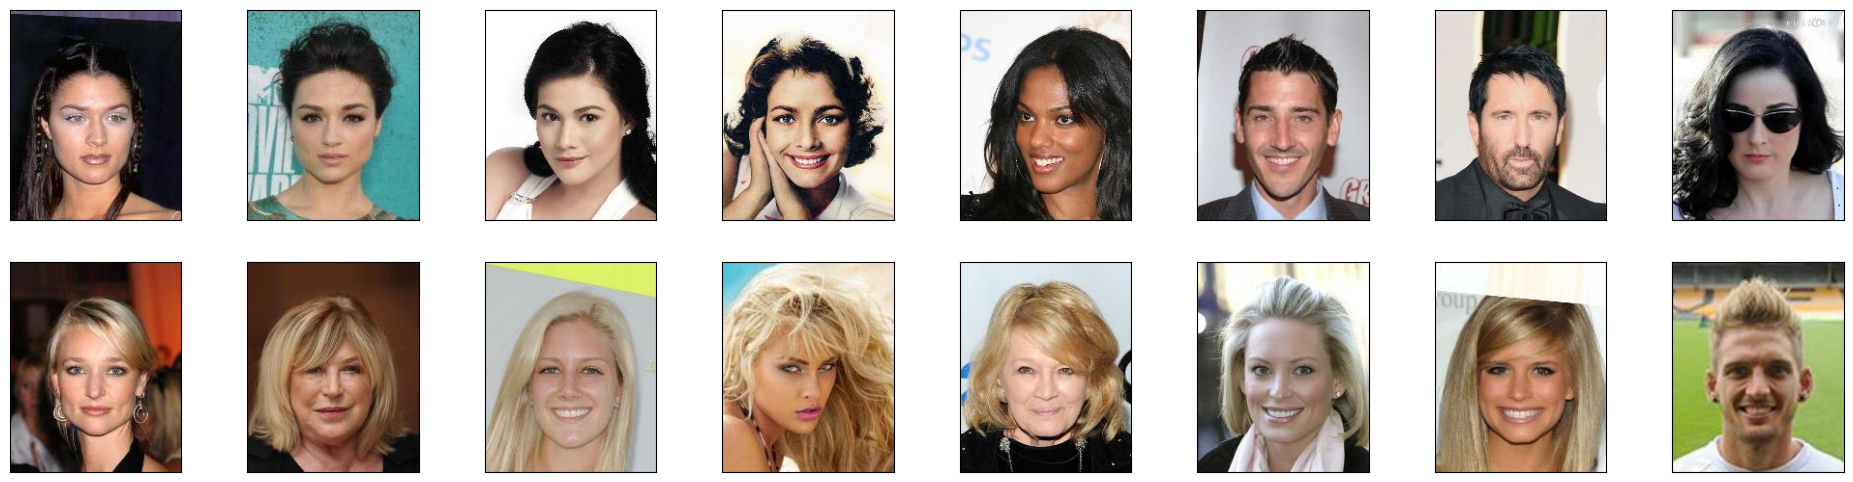

In [7]:
imgs = os.listdir(trainA)
samples = random.sample(imgs,8)
imgs_b = os.listdir(trainB)
samples_b = random.sample(imgs_b,8)
plt.figure(figsize=(24,6))
for i in range(16):
    ax=plt.subplot(2,8,i+1)
    if i<8:
        img=Image.open(fr"{trainA}{samples[i]}")
        plt.imshow(img)
    else:
        img=Image.open(fr"{trainB}{samples_b[7-i]}")
        plt.imshow(img)
    plt.xticks([])

    plt.yticks([])

In [8]:
# process black and blond hair image data 
class LoadData(Dataset):
    def __init__(self, root_A, root_B, transform=None):
        super().__init__()
        self.root_A = root_A
        self.root_B = root_B
        self.transform = transform
        self.A_images = []
        for r in root_A:
            files=os.listdir(r)
            self.A_images += [r+i for i in files]
        self.B_images = []
        for r in root_B:
            files=os.listdir(r)
            self.B_images += [r+i for i in files]      
        self.len_data = max(len(self.A_images),
                            len(self.B_images))
        self.A_len = len(self.A_images)
        self.B_len = len(self.B_images)
    def __len__(self):
        return self.len_data
    def __getitem__(self, index):
        A_img = self.A_images[index % self.A_len]
        B_img = self.B_images[index % self.B_len]
        A_img = np.array(Image.open(A_img).convert("RGB"))
        B_img = np.array(Image.open(B_img).convert("RGB"))
        if self.transform:
            augmentations = self.transform(image=B_img,
                                           image0=A_img)
            B_img = augmentations["image"]
            A_img = augmentations["image0"]
        return A_img, B_img 




In [9]:
transforms = albumentations.Compose([
    albumentations.Resize(width=256,height=256),
    albumentations.HorizontalFlip(p=0.5),
    albumentations.Normalize(mean=[0.5,0.5,0.5],
    std=[0.5,0.5,0.5],max_pixel_value=255),
    ToTensorV2()
],
additional_targets={"image0":"image"})

dataset=LoadData(root_A=["files/black/"],root_B=["files/blond/"],transform=transforms)
loader = DataLoader(dataset,shuffle=True,batch_size=1,pin_memory=True)

In [10]:
# Building a CycleGAN 
class Block(nn.Module):
    def __init__(self,in_ch,out_ch,stride):
        super().__init__()
        self.conv=Sequential(
            Conv2d(in_ch,out_ch,4,stride,1,padding_mode="reflect"),
            nn.InstanceNorm2d(out_ch),
            LeakyReLU(0.2,inplace=True)
        )
    def forwward(self,x):
        return self.conv(x)

class Discriminator(nn.Module):
    def __init__(self,in_ch=3,features=[64,128,256,521]):
        super().__init__()
        self.initial=Sequential(
            Conv2d(in_ch,features[0],kernel_size=4,stride=2,padding=1,padding_mode="reflect"),
            LeakyReLU(0.2,inplace=True)
        )
        layers=[] # now we smartly pack the layers 
        in_ch = features[0]
        for feature in features[1:]: # first layer was of color channel and 64 and from now we add new layers with a for loop
            layers.append(Block(in_ch,feature,stride= 1 if feature==features[-1]else 2))
            in_ch=feature # the transition of input neurons of subsequent layers 
        layers.append(Conv2d(in_ch,1,kernel_size=4,stride=1,padding=1,padding_mode="reflect"))
        self.model = Sequential(*layers)

    def forward(self,x):
        return torch.sigmoid(self.model(self.initial(x)))

In [11]:
def weight_inits(m):
    name = m.__class__.__name__
    if name.find('Conv')!=-1 or name.find('Linear')!=-1:
        nn.init.normal_(m.weight.data,0.0,0.02)
        nn.init.constant_(m.weight.data,0.0)
    elif name.find('Norm2d')!=-1:
        nn.init.constant_(m.weight.data,1)
        nn.init.constant_(m.bias.data,0)

In [12]:
device = "cuda" if torch.cuda.is_available() else 'cpu'

In [13]:
disc_A = Discriminator().to(device)
disc_B = Discriminator().to(device)
weight_inits(disc_A)
weight_inits(disc_B)

In [14]:
# Generator 
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, 
                 down=True, use_act=True, **kwargs):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 
                      padding_mode="reflect", **kwargs)
            if down
            else nn.ConvTranspose2d(in_channels, 
                                    out_channels, **kwargs),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True) if use_act else nn.Identity())
    def forward(self, x):
        return self.conv(x)

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            ConvBlock(channels,channels,kernel_size=3,padding=1),
            ConvBlock(channels,channels,
                      use_act=False, kernel_size=3, padding=1))
    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, img_channels, num_features=64,
                 num_residuals=9):
        super().__init__()     
        self.initial = nn.Sequential(
            nn.Conv2d(img_channels,num_features,kernel_size=7,
                stride=1,padding=3,padding_mode="reflect",),
            nn.InstanceNorm2d(num_features),
            nn.ReLU(inplace=True))
        self.down_blocks = nn.ModuleList(
            [ConvBlock(num_features,num_features*2,kernel_size=3,
                       stride=2, padding=1),
            ConvBlock(num_features*2,num_features*4,kernel_size=3,
                stride=2,padding=1)])
        self.res_blocks = nn.Sequential(
            *[ResidualBlock(num_features * 4) 
            for _ in range(num_residuals)])
        self.up_blocks = nn.ModuleList(
            [ConvBlock(num_features * 4, num_features * 2,
                    down=False, kernel_size=3, stride=2,
                    padding=1, output_padding=1),
                ConvBlock(num_features * 2, num_features * 1,
                    down=False,kernel_size=3, stride=2,
                    padding=1, output_padding=1)])
        self.last = nn.Conv2d(num_features * 1, img_channels,
            kernel_size=7, stride=1,
            padding=3, padding_mode="reflect")
        
    def forward(self, x):
        x = self.initial(x)
        for layer in self.down_blocks:
            x = layer(x)
        x = self.res_blocks(x)
        for layer in self.up_blocks:
            x = layer(x)
        return torch.tanh(self.last(x))

In [15]:
gen_A = Generator(3, num_residuals=9).to(device)
gen_B = Generator(3, num_residuals=9).to(device)
weight_inits(gen_A)
weight_inits(gen_B)

In [16]:
import torch.nn as nn

l1 = nn.L1Loss()
mse = nn.MSELoss()
g_scaler = torch.cuda.amp.GradScaler()
d_scaler = torch.cuda.amp.GradScaler()

/tmp/ipykernel_3973/1978380629.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  g_scaler = torch.cuda.amp.GradScaler()
/tmp/ipykernel_3973/1978380629.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  d_scaler = torch.cuda.amp.GradScaler()


In [17]:
lr = 0.00001
opt_disc = torch.optim.Adam(list(disc_A.parameters()) + list(disc_B.parameters()),lr=lr,betas=(0.5, 0.999))
opt_gen = torch.optim.Adam(list(gen_A.parameters()) + list(gen_B.parameters()),lr=lr,betas=(0.5, 0.999))

# training code 

In [18]:
gen_A.load_state_dict(torch.load("files/gen_black.pth",
map_location=device))
gen_B.load_state_dict(torch.load("files/gen_blond.pth",
map_location=device))

<All keys matched successfully>

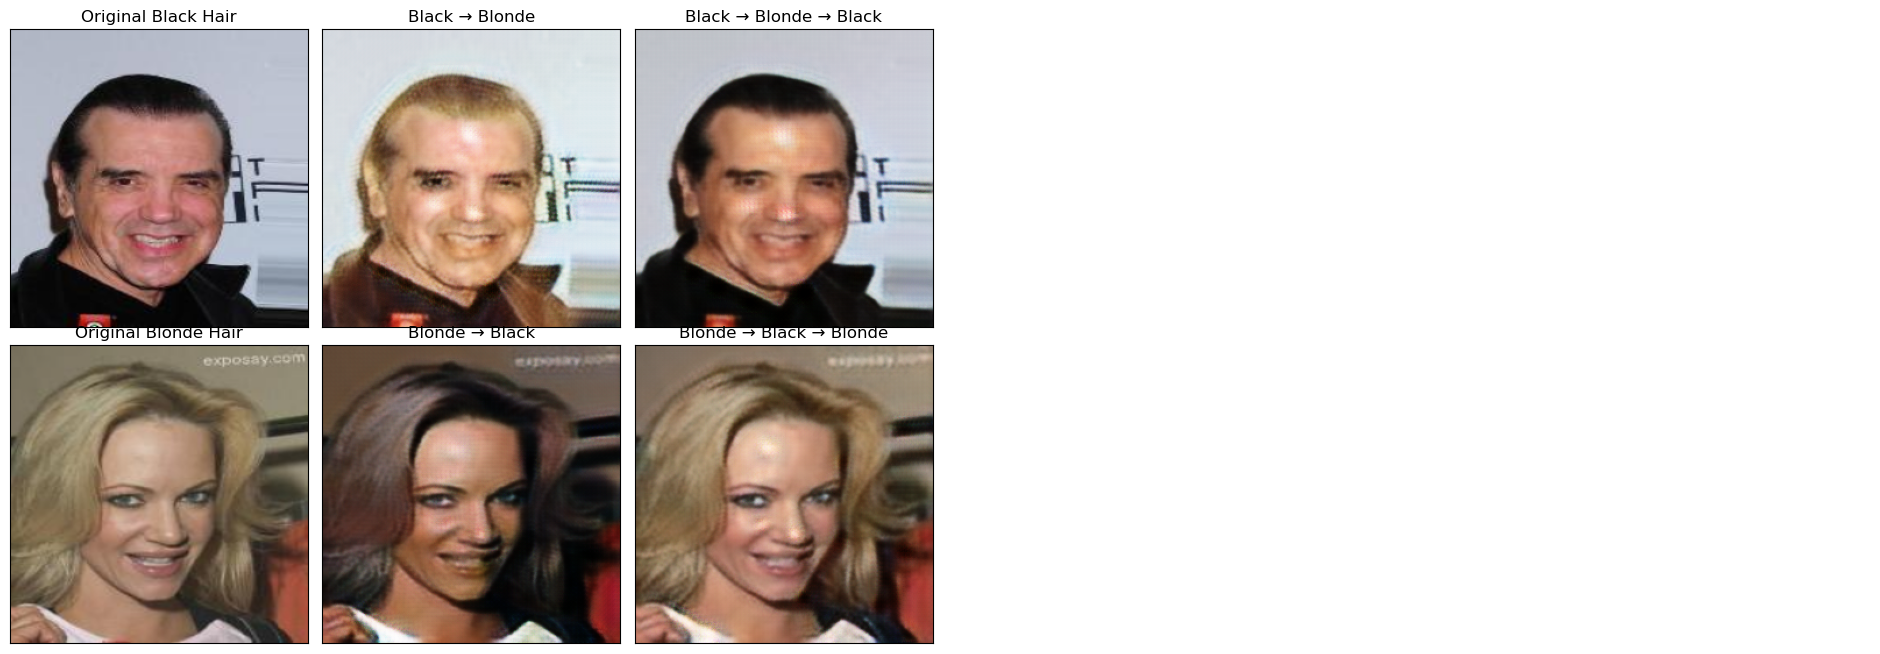

In [20]:
import matplotlib.pyplot as plt

i = 1
fig, axes = plt.subplots(2, 6, figsize=(24, 8))
plt.subplots_adjust(wspace=0.05, hspace=0.05)

for black, blond in loader:
    # Generate transformations
    fake_blond = gen_B(black.to(device))
    fake2black = gen_A(fake_blond)
    fake_black = gen_A(blond.to(device))
    fake2blond = gen_B(fake_black)
    
    # Move tensors to CPU and convert to numpy for plotting
    black_np = (black[0].cpu().detach().permute(1, 2, 0).numpy() * 0.5 + 0.5).clip(0, 1)
    fake_blond_np = (fake_blond[0].cpu().detach().permute(1, 2, 0).numpy() * 0.5 + 0.5).clip(0, 1)
    fake2black_np = (fake2black[0].cpu().detach().permute(1, 2, 0).numpy() * 0.5 + 0.5).clip(0, 1)
    blond_np = (blond[0].cpu().detach().permute(1, 2, 0).numpy() * 0.5 + 0.5).clip(0, 1)
    fake_black_np = (fake_black[0].cpu().detach().permute(1, 2, 0).numpy() * 0.5 + 0.5).clip(0, 1)
    fake2blond_np = (fake2blond[0].cpu().detach().permute(1, 2, 0).numpy() * 0.5 + 0.5).clip(0, 1)
    
    # First row: Black hair and its transformations
    axes[0, 0].imshow(black_np)
    axes[0, 0].set_title('Original Black Hair')
    axes[0, 1].imshow(fake_blond_np)
    axes[0, 1].set_title('Black → Blonde')
    axes[0, 2].imshow(fake2black_np)
    axes[0, 2].set_title('Black → Blonde → Black')
    
    # Second row: Blonde hair and its transformations
    axes[1, 0].imshow(blond_np)
    axes[1, 0].set_title('Original Blonde Hair')
    axes[1, 1].imshow(fake_black_np)
    axes[1, 1].set_title('Blonde → Black')
    axes[1, 2].imshow(fake2blond_np)
    axes[1, 2].set_title('Blonde → Black → Blonde')
    
    # Remove axes
    for row in axes:
        for ax in row:
            ax.set_xticks([])
            ax.set_yticks([])
    
    i += 1
    if i > 5:  # Show 5 sets of transformations
        # If we have empty slots, hide their axes
        for j in range(3, 6):
            axes[0, j].axis('off')
            axes[1, j].axis('off')
        break


In [21]:
def process_custom_image(image_path, gen_A, gen_B, device):
    # 1. Load the image
    input_image = Image.open(image_path).convert("RGB")
    
    # 2. Apply the same transformations you used for training
    transform = albumentations.Compose([
        albumentations.Resize(width=256, height=256),
        albumentations.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255),
        ToTensorV2()
    ])
    
    # Convert to numpy and apply transformations
    input_np = np.array(input_image)
    transformed = transform(image=input_np)
    input_tensor = transformed["image"].unsqueeze(0).to(device)  # Add batch dimension
    
    # 3. Generate transformations
    with torch.no_grad():  # No need to track gradients for inference
        if "black" in image_path.lower():
            # If input is black hair, transform to blonde
            fake_blond = gen_B(input_tensor)
            fake_black_again = gen_A(fake_blond)
            
            # Prepare outputs for display
            results = [
                ("Original (Black Hair)", input_tensor),
                ("Generated Blonde Hair", fake_blond),
                ("Reconstructed Black Hair", fake_black_again)
            ]
        else:
            # If input is blonde hair, transform to black
            fake_black = gen_A(input_tensor)
            fake_blond_again = gen_B(fake_black)
            
            # Prepare outputs for display
            results = [
                ("Original (Blonde Hair)", input_tensor),
                ("Generated Black Hair", fake_black),
                ("Reconstructed Blonde Hair", fake_blond_again)
            ]
    
    # 4. Visualize results
    plt.figure(figsize=(15, 5))
    
    for idx, (title, img_tensor) in enumerate(results):
        # Denormalize: * 0.5 + 0.5 to convert from [-1, 1] to [0, 1]
        img = img_tensor[0].cpu().detach().permute(1, 2, 0).numpy() * 0.5 + 0.5
        img = np.clip(img, 0, 1)  # Ensure values are in valid range
        
        plt.subplot(1, 3, idx + 1)
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    


In [22]:
def process_images_from_folder(folder_path, gen_A, gen_B, device, num_images=5):
    # Get all jpeg files from the folder
    image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) 
                  if f.lower().endswith(('.jpg', '.jpeg'))]
    
    # Select a subset if there are too many
    if len(image_files) > num_images:
        import random
        image_files = random.sample(image_files, num_images)
    
    # Process each image
    all_results = []
    for path in image_files:
        result = process_custom_image(path, gen_A, gen_B, device)
        all_results.append((path, result))
    
    

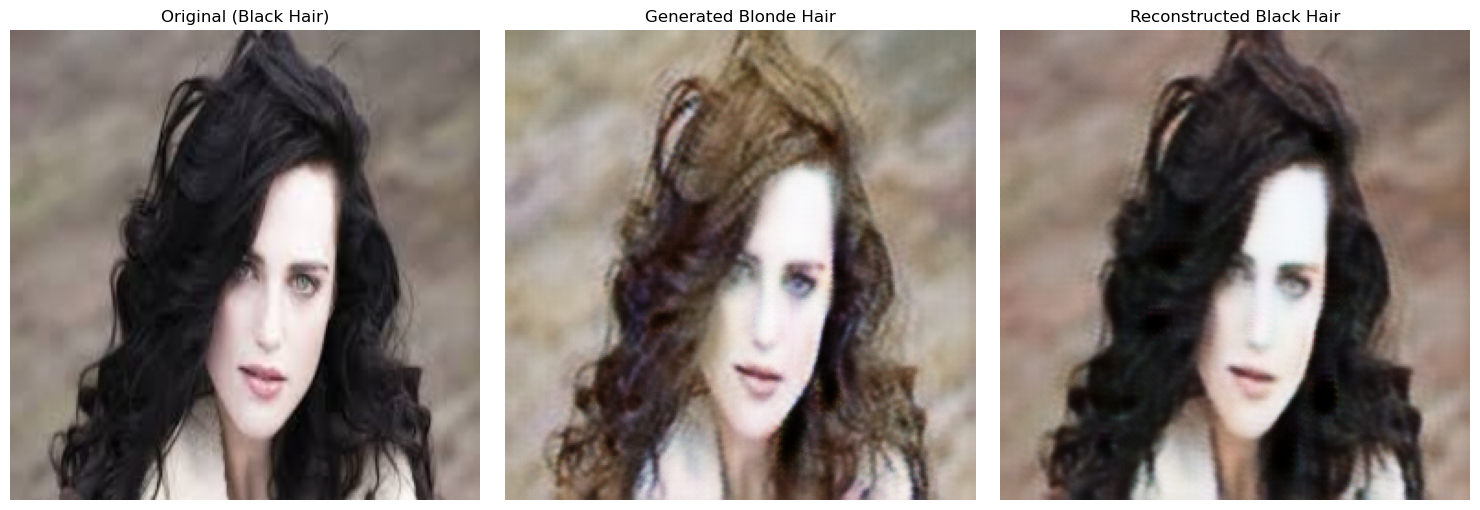

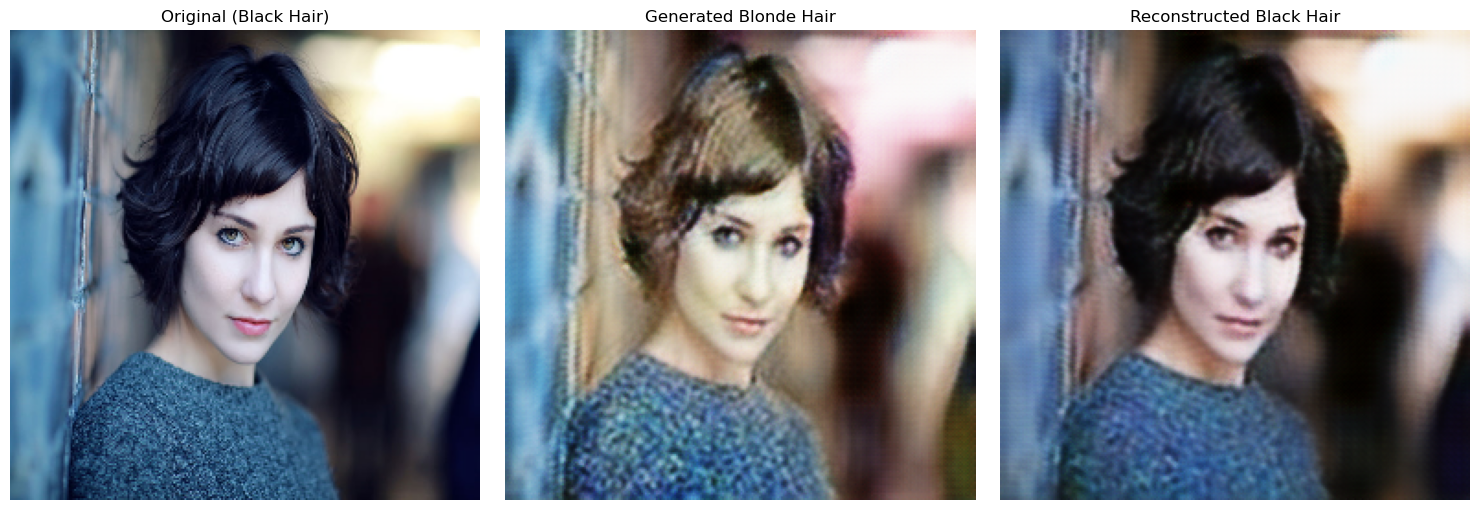

In [23]:
test_folder = "test/black"
process_images_from_folder(test_folder, gen_A, gen_B, device, num_images=3)

In [ ]:
test_folder = "test/blond"
results = process_images_from_folder(test_folder, gen_A, gen_B, device, num_images=3)

In [24]:
img =r"test/black/Screenshot 2025-02-27 at 21-38-14 Instagram.png"

In [40]:
Img = Image.open(img).convert("RGB")
img_arr = np.array(Img)
img_arr_ts=torch.tensor(img_arr).permute(2,0,1).to(device)
img_arr_ts.shape

torch.Size([3, 894, 900])

In [43]:
    transform = albumentations.Compose([
        albumentations.Resize(width=256, height=256),
        albumentations.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255),
        ToTensorV2()
    ])
transformed = transform(image=img_arr)
input_tensor = transformed["image"].unsqueeze(0).to(device)

In [44]:
with torch.no_grad():  # No need to track gradients for inference
        
            # If input is black hair, transform to blonde
            fake_blond = gen_B(input_tensor)
            fake_black_again = gen_A(fake_blond)
            
            # Prepare outputs for display
            results = [
                ("Original (Black Hair)", input_tensor),
                ("Generated Blonde Hair", fake_blond),
                ("Reconstructed Black Hair", fake_black_again)
            ]

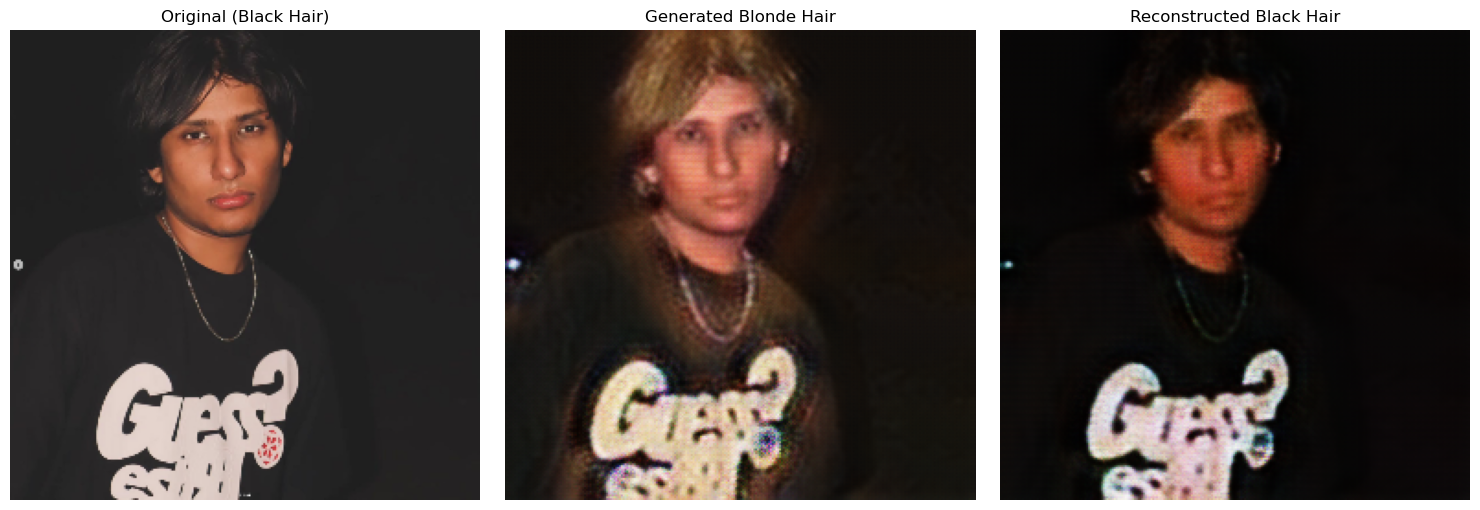

In [46]:
    plt.figure(figsize=(15, 5))
    
    for idx, (title, img_tensor) in enumerate(results):
        # Denormalize: * 0.5 + 0.5 to convert from [-1, 1] to [0, 1]
        img = img_tensor[0].cpu().detach().permute(1, 2, 0).numpy() * 0.5 + 0.5
        img = np.clip(img, 0, 1)  # Ensure values are in valid range
        
        plt.subplot(1, 3, idx + 1)
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    